In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import dense_output, ivpsolve, solvers
from probdiffeq.implementations import recipes
from probdiffeq.strategies import smoothers

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax


config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

In [2]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.fitzhugh_nagumo(time_span=(0.0, 1.0))


@jax.jit
def vector_field(y, *, t, p):
    return f(y, *p)


# Make a solver
solver = solvers.MLESolver(
    smoothers.Smoother(recipes.IsoTS0.from_params(num_derivatives=2))
)

In [3]:
%%time
ts = jnp.linspace(t0, t1, endpoint=True, num=5)
solution = ivpsolve.solve_fixed_grid(
    vector_field,
    initial_values=(u0,),
    grid=ts,
    solver=solver,
    parameters=f_args,
)

CPU times: user 1.3 s, sys: 11.6 ms, total: 1.31 s
Wall time: 1.29 s


In [4]:
eps = 1e-4
mesh = jnp.linspace(t0 + eps, t1 - eps, endpoint=True)

In [5]:
u, marginals = dense_output.offgrid_marginals_searchsorted(
    ts=mesh, solution=solution, solver=solver
)

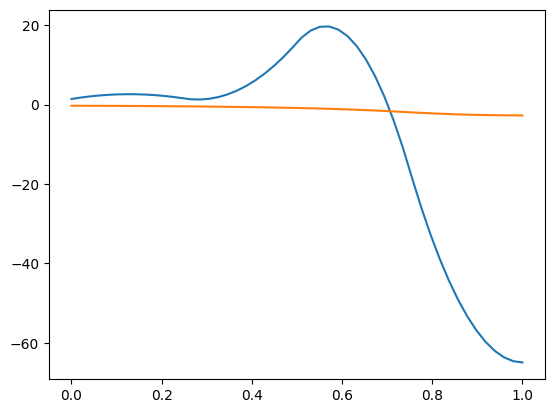

In [6]:
rv = marginals.marginal_nth_derivative(n=2)
plt.plot(mesh, rv.mean)
plt.show()

NameError: name 'stdev' is not defined

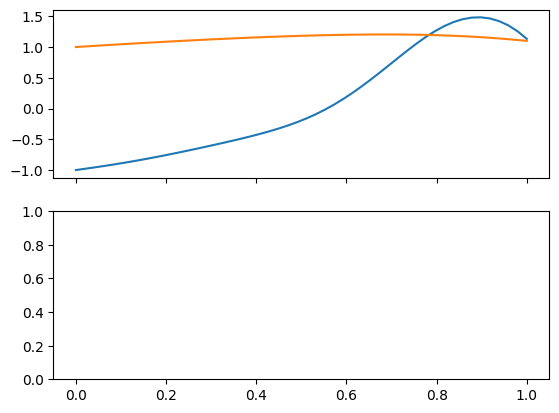

In [7]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].plot(mesh, u, "-")

c = 1.96
for u_ in u.T:
    ax[0].fill_between(mesh, u_ - c * stdev, u_ + c * stdev)

ax[0].plot(solution.t, solution.u, "o-")
ax[1].semilogy(mesh, stdev)
plt.show()